# ReLU-Field toy problem analysis on 2D image

In [1]:
import torch
import matplotlib.pyplot as plt
import imageio
import numpy as np
import pickle

# from livelossplot import PlotLosses
from PIL import Image, ImageDraw
from pathlib import Path
from torch.nn.functional import interpolate
from thre3d_atom.utils.fancy_resizing_utils import resize_right, interp_methods

Hardware check:

In [2]:
torch.__version__ 

'1.11.0+cu102'

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device being used: {device}")
if torch.cuda.is_available():
    print(f"Device information: {torch.cuda.get_device_name(torch.cuda.current_device())}")

Device being used: cuda
Device information: NVIDIA GeForce GTX 1080


In [4]:
# =============================================================================================
# Tweakable notebook parameters
# =============================================================================================
input_image_path = Path("data/nat_img_3_ucl_colour_graded.jpg")
output_dir = Path("./models")
vis_save_path = Path("./visualizations")

fig_size = (16, 12)
image_downsample_factor = 1
grid_downsample_factor = 8
# =============================================================================================

Load and display the image being used:

/tmp/ipykernel_2710528/992732470.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(input_image_path, pilmode="RGBA")


Image dimensions: (576, 768, 4)


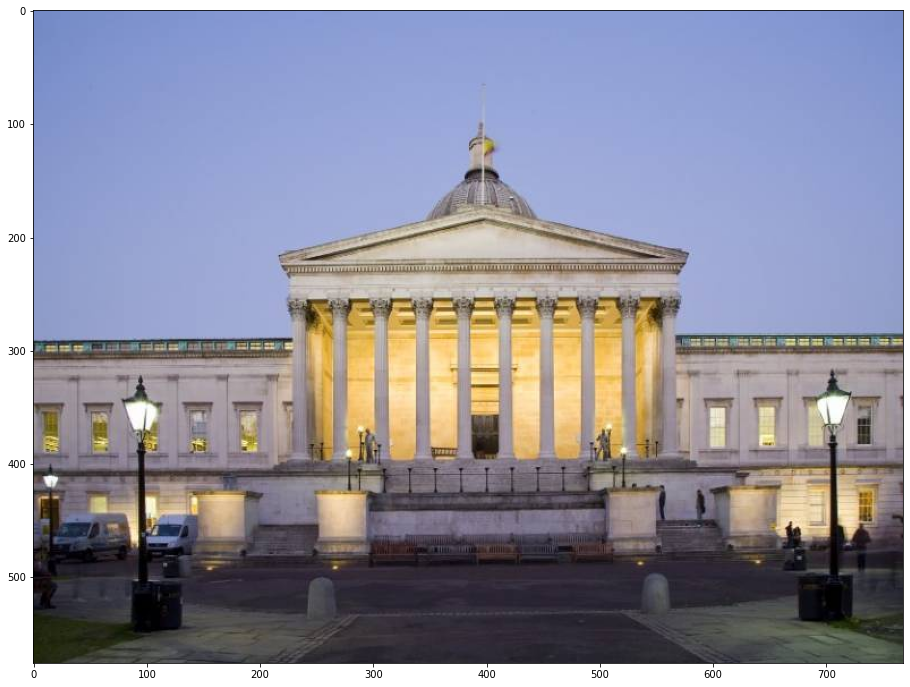

In [5]:
image = imageio.imread(input_image_path, pilmode="RGBA")
image_height, image_width, _ = image.shape
image = np.array(Image.fromarray(image).resize((int(image_width / image_downsample_factor), 
                                               int(image_height / image_downsample_factor))))
print(f"Image dimensions: {image.shape}")

# display the image:
plt.figure(figsize=fig_size)
plt.imshow(image);

In [ ]:
#-----------------------------------------------------------------------------------------
#  Change this if working with alpha_only images or with RGB images                    # |
# ----------------------------------------------------------------------------------------
alpha_only = False                                                                      # |
# ----------------------------------------------------------------------------------------

In [ ]:
if alpha_only:
    # THIS IS AN RGBA image whose, we just need to use the BINARIZED ALPHA channel
    image = image[..., :-1].astype(np.float32) / 255.0
    image = image.mean(axis=-1, keepdims=True)
    image[image < 0.5] = 0.0
else:
    # THIS IS AN RGB image and we will be using all three channels of it
    image = image[..., :3].astype(np.float32) / 255.0


print(f"Image min: {image.min()}   max: {image.max()}")
print(f"Image dims: {image.shape}   dtype: {image.dtype}")

# display the image post normalization:
plt.figure(figsize=fig_size)
plt.imshow(image, cmap="gray");

Define the ImageGrid class: This has two modes: Normal grid mode and ReLU-field mode

In [ ]:
class ImageGrid(torch.nn.Module):
    class SoftClipActivation(torch.nn.Module):
        def __init__(self):
            super().__init__()
        def forward(self, x):
            return (1 - torch.exp(-x))
        
    class HardClipActivation(torch.nn.Module):
        def __init__(self):
            super().__init__()
        def forward(self, x):
            return torch.clip(x, 0.0, 1.0)
    
    def __init__(self, grid_dims, use_relu_field, activation=None, interpolation_mode=None):
        super().__init__()
        
        # state of the object
        # change the following if working with coloured or non-coloured images
        self._num_channels = 3 
        self._grid_dims = grid_dims
        self._use_relu_field = use_relu_field
        
        # we initialize the resolution like this, but it changes once the grid has been optimised
        # Also, the render interface can render this grid at any resolution
        self._render_resolution = grid_dims
        self._interpolation_mode = interpolation_mode
        
        # create a feature-grid with the feature dims
        self._features = torch.empty(*self._grid_dims, self._num_channels)
        self._features = torch.nn.init.xavier_uniform_(self._features)
        self._features = torch.nn.Parameter(self._features)
        
        self._preactivation = torch.nn.Identity() if use_relu_field else torch.abs
        
        # note that self.activation is not private
        if activation is None:
            if use_relu_field:
                self.activation = torch.nn.ReLU()
            else:
                self.activation = torch.nn.Identity()
        else:
            self.activation = activation
        
        self._clipper = self.HardClipActivation()
        
        # manually defined parameters (hackily :)), but they work and don't need to be changed at all
        self._num_stages = 6
        self._scale_factor = 2.0
    
    @property
    def raw_features(self):
        return self._features
    
    def get_save_info(self):
        return {
            "conf": {
                "grid_dims": self._grid_dims,
                "use_relu_field": self._use_relu_field,
                "activation": self.activation,
                "interpolation_mode": self._interpolation_mode,
            },
            "state_dict": self.state_dict(),
        }
    
    def render(self, resolution = None, plot_grid = True):
        device = self._features.device
        height, width = resolution if resolution is not None else self._resolution
        with torch.no_grad():
            query_coords = torch.stack(torch.meshgrid(torch.linspace(-1, 1, height, device=device), 
                                                      torch.linspace(-1, 1, width, device=device), 
                                                      indexing="ij"), dim=-1)
            # note the flip is needed for the grid-sample convention
            query_coords = torch.flip(query_coords, dims=(-1,))
            rendered_image = self(query_coords.reshape(-1, 2))
            rendered_image = rendered_image.reshape(height, width, -1)
            
        rendered_image = rendered_image.cpu().numpy()
        
        # plot the grid on-top if required:
        if plot_grid:
            if self._num_channels != 3:
                tiled_image = np.tile(rendered_image, (1, 1, 3))
            else:
                tiled_image = rendered_image
            drawable_image = Image.fromarray(self.to8b(tiled_image))
            draw = ImageDraw.Draw(drawable_image)
            
            # vertical lines:
            y_start = 0
            y_end = drawable_image.height
            step_size = int(drawable_image.width / self._features.shape[1])
            for x in range(0, drawable_image.width, step_size):
                line = ((x, y_start), (x, y_end))
                draw.line(line, fill=(52, 0, 84), width=5)
                
            # horizontal lines:
            x_start = 0
            x_end = drawable_image.width
            step_size = int(drawable_image.height / self._features.shape[0])
            for y in range(0, drawable_image.height, step_size):
                line = ((x_start, y), (x_end, y))
                draw.line(line, fill=(52, 0, 84), width=5)
        
        return np.array(drawable_image)
    
    def forward(self, coords):
        # choose an appropriate interpolation mode 
        interpolation_mode = self._interpolation_mode if self._interpolation_mode is not None else "bilinear"
        
        # interpolate the features' grid
        preactivated_features = self._preactivation(self._features)
        decoded_features = torch.nn.functional.grid_sample(preactivated_features.permute(2, 0, 1)[None, ...],
                                                         coords[None, None, ...], 
                                                         mode=interpolation_mode,
                                                         align_corners=False)
        decoded_features = decoded_features.permute(0, 2, 3, 1).squeeze(0).squeeze(0)
        alpha = self._clipper(self.activation(decoded_features))
        
        return alpha
    
    @staticmethod
    def to8b(x):
        if isinstance(x, torch.Tensor):
            x = x.detach().cpu().numpy()
        return (255 * np.clip(x, 0, 1)).astype(np.uint8)

    @staticmethod
    def mse2psnr(x):
        return (-10.0 * np.log(x) / np.log(10.0)).item()

    def extra_repr(self):
        return f"Grid size: {*self._grid_dims, self._num_channels}"

    @staticmethod
    def compute_grid_sizes_2d(output_resolution, num_stages, scale_factor):
        x, y = output_resolution
        grid_sizes = [(x, y)]
        for _ in range(num_stages - 1):
            x = int(np.ceil((1 / scale_factor) * x))
            y = int(np.ceil((1 / scale_factor) * y))
            grid_sizes.insert(0, (x, y))
        return grid_sizes
    
    def compute_training_images_pyramid(self, training_image):
        # bring the training image on the device:
        training_image = training_image.to(device)
        
        image_sizes = self.compute_grid_sizes_2d(training_image.shape[:-1], 
                                                 self._num_stages, 
                                                 self._scale_factor)
        pyramid = []
        for image_size in image_sizes:
            pyramid.append(resize_right.resize(training_image.permute(2, 0, 1)[None, ...], 
                                  out_shape=image_size,
                                  interp_method=interp_methods.linear
                                 )[0].permute(1, 2, 0))
        pyramid[-1] = training_image
        
        return pyramid
    
    def train(self, training_image, num_iterations=10000, lr=0.03, decay_steps=4000, decay_gamma=0.5,
              feedback_frequency=100):
        device = self._features.device
        img_height, img_width, img_channels = training_image.shape
        assert img_channels == self._num_channels, f"Training image incompatible with the grid"
        
        # update the render-resolution to the one that we trained on:
        self._resolution = (img_height, img_width)

        # compute and display training_images pyramid:
        stagewise_training_images = self.compute_training_images_pyramid(training_image)
        print("Displaying the stagewise training_images")
        for image_stage, image in enumerate(stagewise_training_images, 1):
            plt.figure(figsize=fig_size)
            plt.title(f"Pyramid stage: {image_stage}")
            plt.imshow(image.detach().cpu(), cmap="gray")
        
        # setup stagewise training mechanism for the feature-grid:
        stagewise_grid_sizes = self.compute_grid_sizes_2d(self._features.shape[:-1], 
                                                         self._num_stages, self._scale_factor)
        with torch.no_grad():
            features = interpolate(self._features.permute(2, 0, 1)[None, ...], size=stagewise_grid_sizes[0])
            self._features = torch.nn.Parameter(features[0].permute(1, 2, 0))
        
        # start the training loop
        print(f"Starting training ... please stand by.")
        data_buffer = {"loss": [], "psnr": []}
        for stage in range(1, self._num_stages + 1):
            print(f"Training stage: {stage}   grid_resolution: {self._features.shape}")
            current_stage_training_image = stagewise_training_images[stage - 1]
            
            # setup the training optimizer:
            # (note that the parameters change after every stage ... )
            optimizer = torch.optim.Adam(self.parameters(), lr=lr)
            print(f"current learning rate: {optimizer.param_groups[0]['lr']}")
            
            # learning_rate scheduler:
            lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decay_gamma)
            
            for iter_ in range(1, num_iterations + 1):
                # sample the current bacth of pixel-coordinates and pixels for optimization:
                current_img_height, current_img_width, _ = current_stage_training_image.shape
                half_pixel_ht, half_pixel_width = 1 / current_img_height, 1 / current_img_width
                ht_coord_min, ht_coord_max = -1 + half_pixel_ht, 1 - half_pixel_ht
                wd_coord_min, wd_coord_max = -1 + half_pixel_width, 1 - half_pixel_width
                num_pixels_per_batch = img_height * img_width
                
                i_coords = torch.rand((num_pixels_per_batch, 1), dtype=torch.float32, device=device)
                i_coords = ht_coord_min + (i_coords * (ht_coord_max - ht_coord_min))

                j_coords = torch.rand((num_pixels_per_batch, 1), dtype=torch.float32, device=device)
                j_coords = wd_coord_min + (j_coords * (wd_coord_max - wd_coord_min))

                
                image_pixel_coords = torch.cat([i_coords, j_coords], dim=-1).reshape(img_height, img_width, -1)
                pixel_values = torch.nn.functional.grid_sample(training_image.permute(2, 0, 1)[None, ...],
                                                               image_pixel_coords[None, ...],
                                                               mode="bilinear",
                                                               align_corners=False)
                pixel_values = pixel_values.squeeze(0).permute(1, 2, 0)

                data_tensor = torch.cat([pixel_values, image_pixel_coords], dim=-1)
                dataset = data_tensor.reshape(-1, img_channels + 2)
                
                
                pixels, pixel_coords = dataset[:, :-2], dataset[:, -2:]

                # foward pass and compute the loss
                rendered_values = self(pixel_coords)
                loss = torch.nn.functional.mse_loss(rendered_values, pixels)
                psnr = self.mse2psnr(torch.nn.functional.mse_loss(rendered_values, pixels).item())

                data_buffer["loss"].append(loss.item())
                data_buffer["psnr"].append(psnr)

                if iter_ % feedback_frequency == 0 or iter_ == (num_iterations - 1):
                    print(f"step: {iter_}  loss: {loss.item()}  psnr: {psnr}")
                
                # one optimizer step
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                # exponential learning_rate decay:
                if iter_ % decay_steps == 0:
                    lr_scheduler.step()
                    print(f"updated learning rate: {optimizer.param_groups[0]['lr']}")

            # training complete
            print(f"Training for stage {stage} is now complete. Rendered RF grid:")
            plt.figure(figsize=fig_size)
            plt.imshow(self.render(), cmap="gray")
            plt.show()
            print(self)

            if stage != self._num_stages:
                with torch.no_grad():
                    grid_size = stagewise_grid_sizes[stage]
                    features = resize_right.resize(
                        self._features.permute(2, 0, 1)[None, ...], 
                        out_shape=grid_size,
                        interp_method=interp_methods.linear,
                    )
                    self._features = torch.nn.Parameter(features[0].permute(1, 2, 0))

        # return the obtained data:
        return data_buffer

Displaying the stagewise training_images
Starting training ... please stand by.
Training stage: 1   grid_resolution: torch.Size([5, 6, 3])
current learning rate: 0.03
step: 100  loss: 0.01576135866343975  psnr: 18.024063481027017
step: 200  loss: 0.015776006504893303  psnr: 18.02002923330939
step: 300  loss: 0.015674574300646782  psnr: 18.048042451633098
step: 400  loss: 0.015645798295736313  psnr: 18.056022729403935
step: 500  loss: 0.01575220376253128  psnr: 18.02658679020103
step: 600  loss: 0.015732284635305405  psnr: 18.032082047474017
step: 700  loss: 0.015736939385533333  psnr: 18.030797279630978
step: 800  loss: 0.015625784173607826  psnr: 18.061581785454806
step: 900  loss: 0.015717852860689163  psnr: 18.0360678109834
step: 999  loss: 0.015763362869620323  psnr: 18.023511269528445
step: 1000  loss: 0.015748484060168266  psnr: 18.0276124479436
Training for stage 1 is now complete. Rendered RF grid:


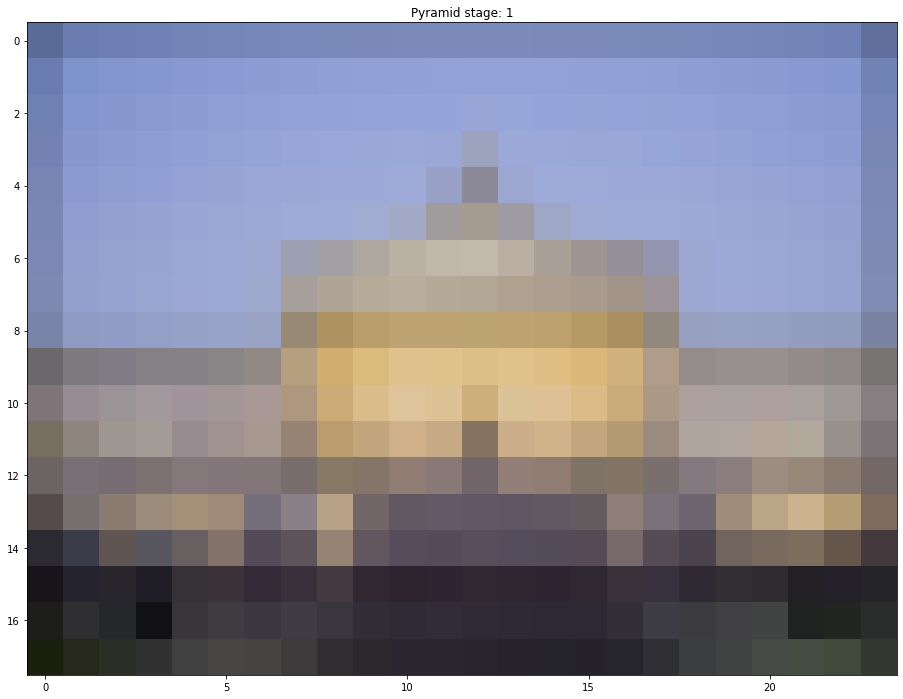

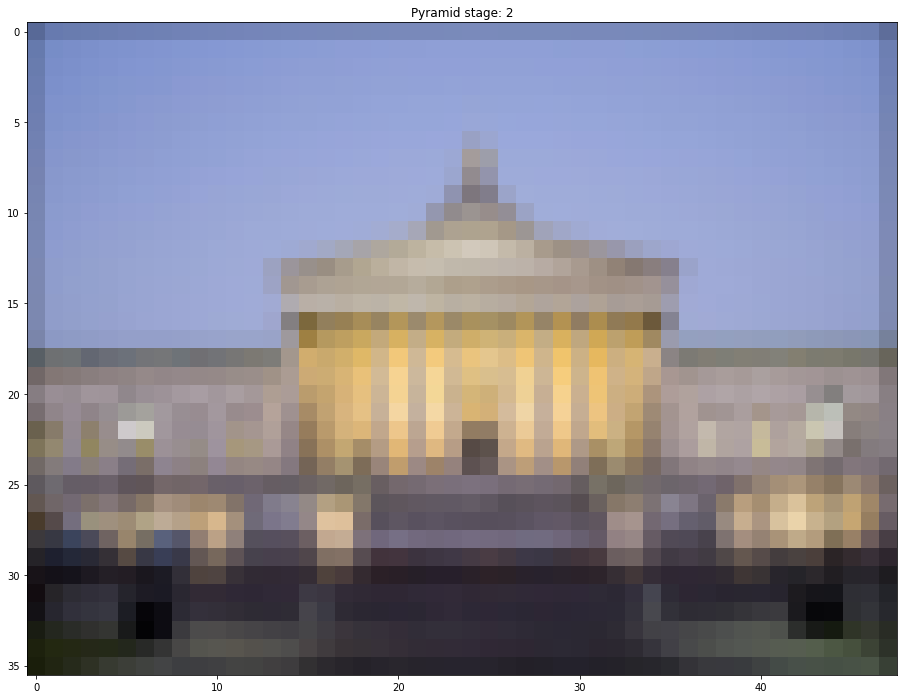

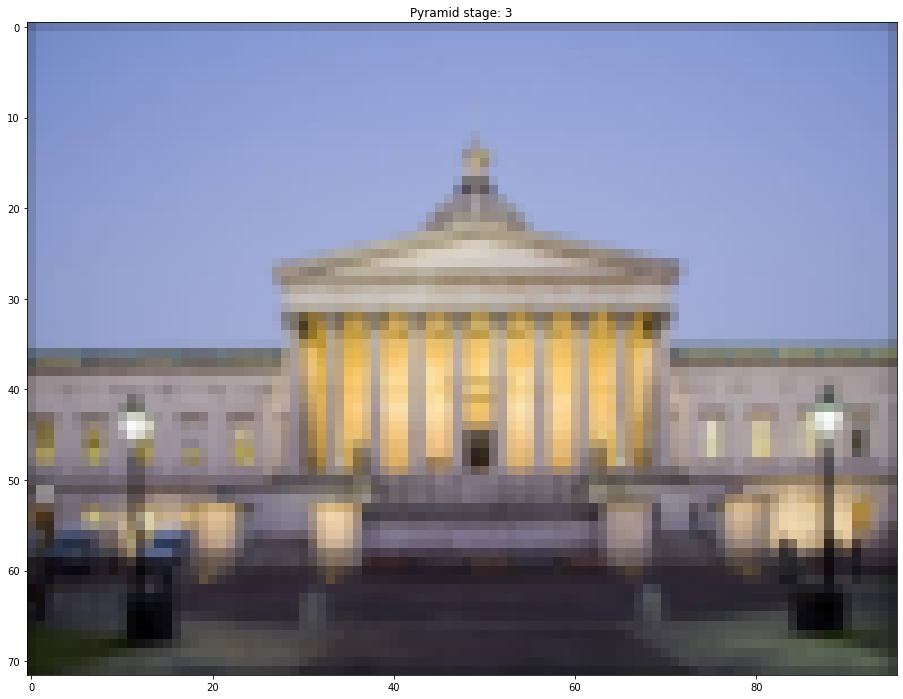

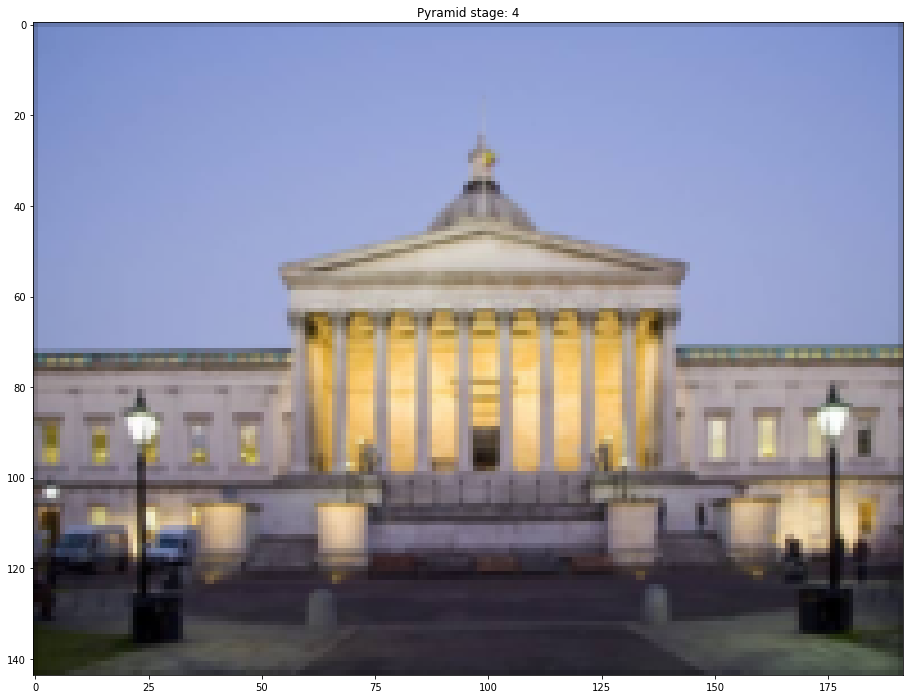

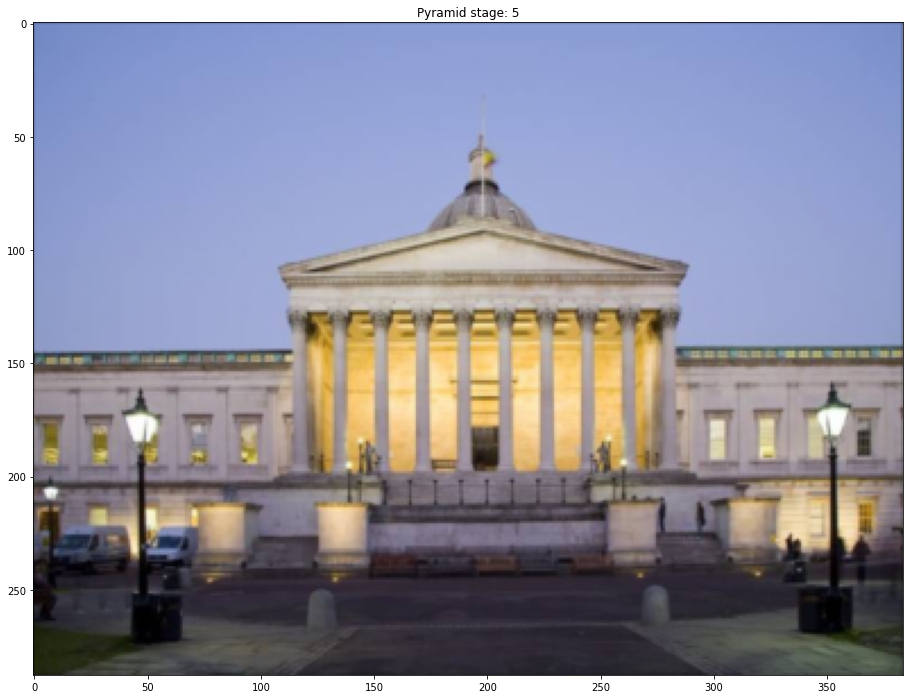

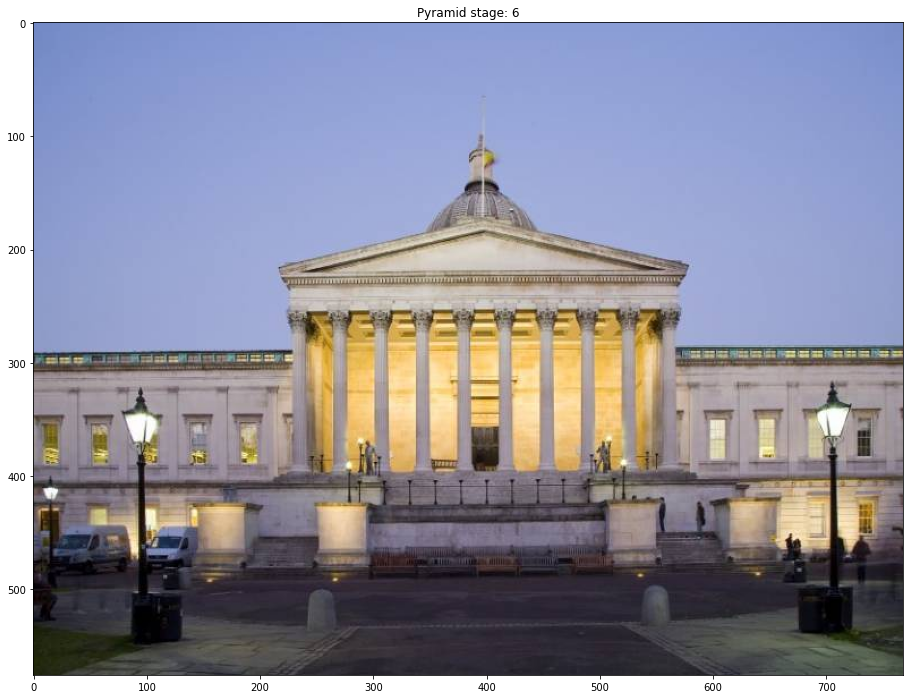

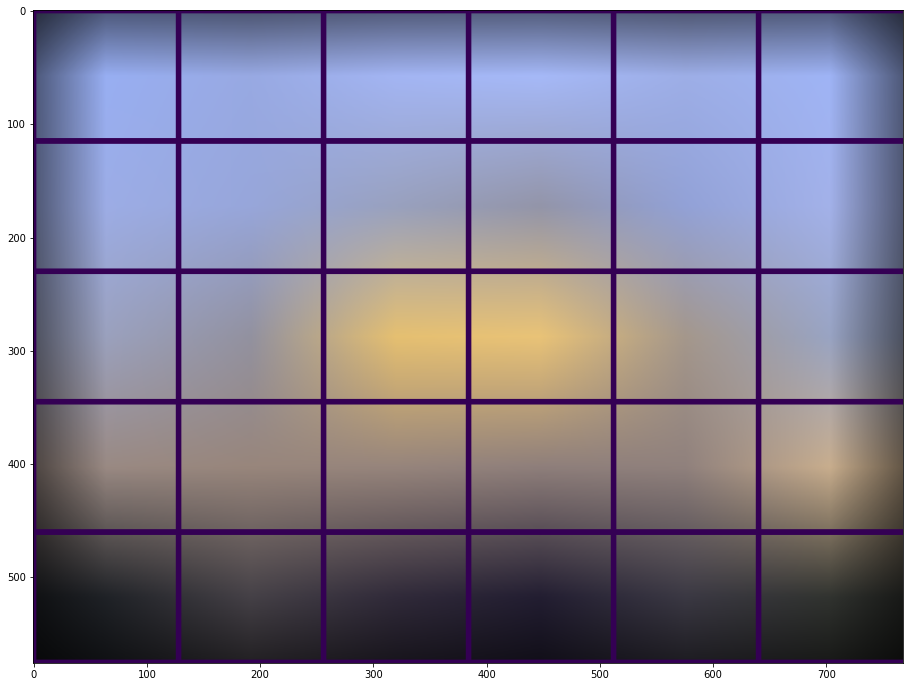

ImageGrid(
  Grid size: (144, 192, 3)
  (_preactivation): Identity()
  (activation): ReLU()
  (_clipper): HardClipActivation()
)
Training stage: 2   grid_resolution: torch.Size([9, 12, 3])
current learning rate: 0.03
step: 100  loss: 0.012779496610164642  psnr: 18.934862528860254
step: 200  loss: 0.012725261971354485  psnr: 18.953332682020047
step: 300  loss: 0.012694176286458969  psnr: 18.963954748494796
step: 400  loss: 0.01275098230689764  psnr: 18.94456356874559
step: 500  loss: 0.01273944228887558  psnr: 18.9484958425856
step: 600  loss: 0.01272284984588623  psnr: 18.954155983010843
step: 700  loss: 0.012735838070511818  psnr: 18.949724713974117
step: 800  loss: 0.012745382264256477  psnr: 18.946471344773656
step: 900  loss: 0.012824839912354946  psnr: 18.919480473167148
step: 999  loss: 0.012799825519323349  psnr: 18.927959503920956
step: 1000  loss: 0.012846929021179676  psnr: 18.912006753327226
Training for stage 2 is now complete. Rendered RF grid:


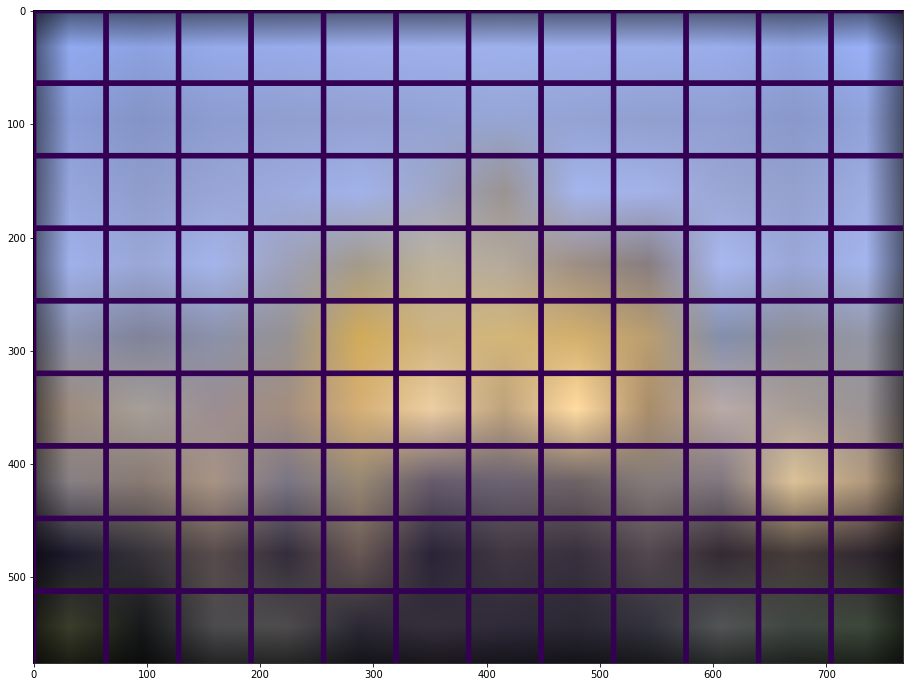

ImageGrid(
  Grid size: (144, 192, 3)
  (_preactivation): Identity()
  (activation): ReLU()
  (_clipper): HardClipActivation()
)
Training stage: 3   grid_resolution: torch.Size([18, 24, 3])
current learning rate: 0.03
step: 100  loss: 0.008307644166052341  psnr: 20.80522113488583
step: 200  loss: 0.008280602283775806  psnr: 20.819380739629892
step: 300  loss: 0.00832319725304842  psnr: 20.797098128168468
step: 400  loss: 0.008308734744787216  psnr: 20.80465105601382
step: 500  loss: 0.008311518467962742  psnr: 20.803196257930892
step: 600  loss: 0.00832586269825697  psnr: 20.795707553374257
step: 700  loss: 0.008300273679196835  psnr: 20.809075876955557
step: 800  loss: 0.008313042111694813  psnr: 20.80240019470395
step: 900  loss: 0.008297393098473549  psnr: 20.810583342242236
step: 999  loss: 0.008333621546626091  psnr: 20.791662259742438
step: 1000  loss: 0.008266175165772438  psnr: 20.826953959666795
Training for stage 3 is now complete. Rendered RF grid:


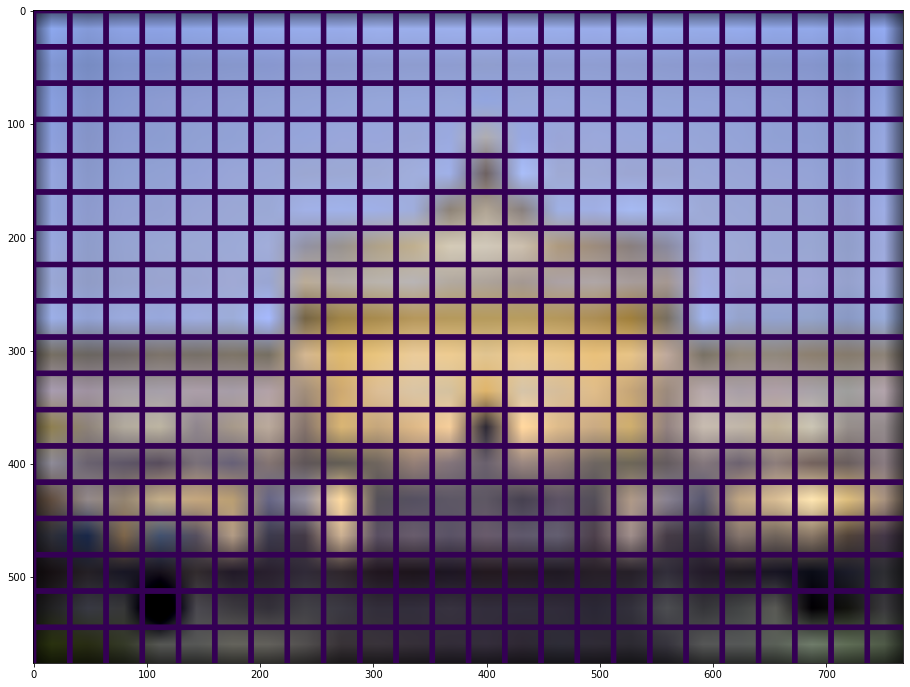

ImageGrid(
  Grid size: (144, 192, 3)
  (_preactivation): Identity()
  (activation): ReLU()
  (_clipper): HardClipActivation()
)
Training stage: 4   grid_resolution: torch.Size([36, 48, 3])
current learning rate: 0.03
step: 100  loss: 0.005029694642871618  psnr: 22.98458380538778
step: 200  loss: 0.005069436505436897  psnr: 22.950403121025488
step: 300  loss: 0.005053399596363306  psnr: 22.964163586717287
step: 400  loss: 0.0050787851214408875  psnr: 22.942401613684144
step: 500  loss: 0.005021615419536829  psnr: 22.99156550796433
step: 600  loss: 0.005069368984550238  psnr: 22.95046096600243
step: 700  loss: 0.005057120695710182  psnr: 22.96096681159742
step: 800  loss: 0.005047260317951441  psnr: 22.969442954774607
step: 900  loss: 0.005007290747016668  psnr: 23.003971906743907
step: 999  loss: 0.005066164303570986  psnr: 22.953207294730014
step: 1000  loss: 0.00507661746814847  psnr: 22.94425560198164
Training for stage 4 is now complete. Rendered RF grid:


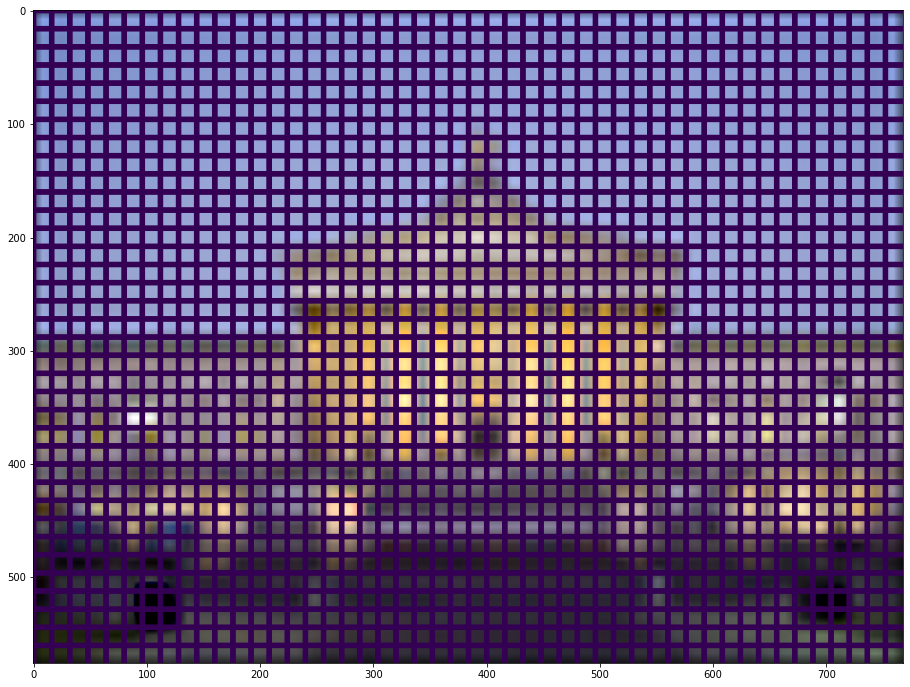

ImageGrid(
  Grid size: (144, 192, 3)
  (_preactivation): Identity()
  (activation): ReLU()
  (_clipper): HardClipActivation()
)
Training stage: 5   grid_resolution: torch.Size([72, 96, 3])
current learning rate: 0.03
step: 100  loss: 0.0026867883279919624  psnr: 25.70766547041386
step: 200  loss: 0.0026841594371944666  psnr: 25.711916909481857
step: 300  loss: 0.002696966053918004  psnr: 25.691245198759457
step: 400  loss: 0.0027068688068538904  psnr: 25.675327925634903
step: 500  loss: 0.0026626759208738804  psnr: 25.74681689115335
step: 600  loss: 0.002673895563930273  psnr: 25.728555592634628
step: 700  loss: 0.002683645347133279  psnr: 25.712748782049616
step: 800  loss: 0.002671460621058941  psnr: 25.732512231965348
step: 900  loss: 0.0026812928263098  psnr: 25.71655753750831
step: 999  loss: 0.0026513992343097925  psnr: 25.765248734727397
step: 1000  loss: 0.002681098645552993  psnr: 25.716872067440164
Training for stage 5 is now complete. Rendered RF grid:


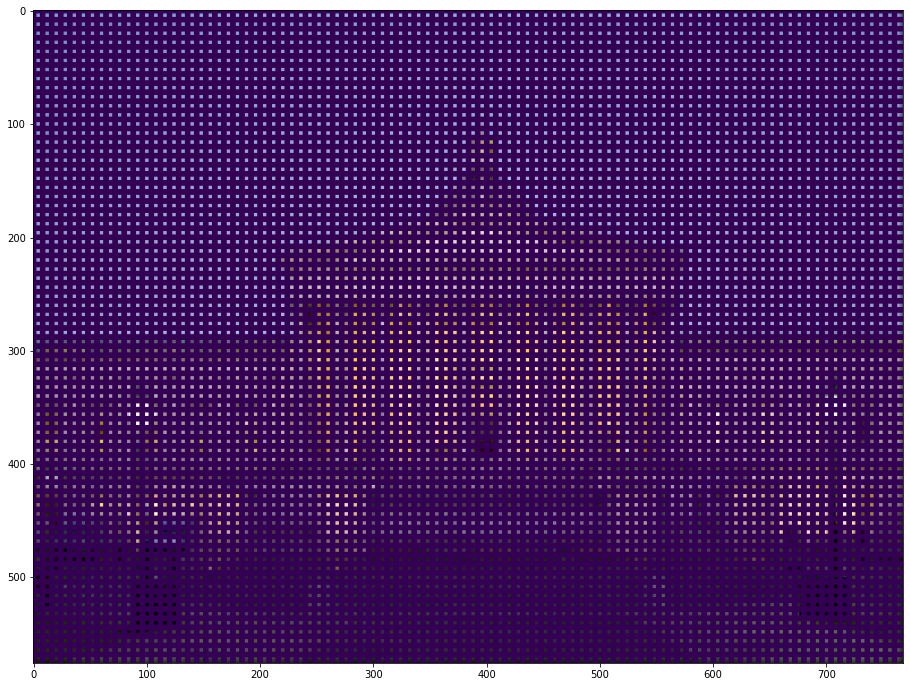

ImageGrid(
  Grid size: (144, 192, 3)
  (_preactivation): Identity()
  (activation): ReLU()
  (_clipper): HardClipActivation()
)
Training stage: 6   grid_resolution: torch.Size([144, 192, 3])
current learning rate: 0.03
step: 100  loss: 0.0011018114164471626  psnr: 29.57892731986005
step: 200  loss: 0.0010988743742927909  psnr: 29.590519542279498
step: 300  loss: 0.0011055385693907738  psnr: 29.564261014060364
step: 400  loss: 0.0011135684326291084  psnr: 29.532830889128437
step: 500  loss: 0.0010987207060679793  psnr: 29.59112690860266
step: 600  loss: 0.001103080459870398  psnr: 29.573928084997025
step: 700  loss: 0.0011054134229198098  psnr: 29.56475266129663
step: 800  loss: 0.0011009792797267437  psnr: 29.58220854311641
step: 900  loss: 0.0011011423775926232  psnr: 29.581565231671227
step: 999  loss: 0.0011123319854959846  psnr: 29.537655743088113
step: 1000  loss: 0.0011018204968422651  psnr: 29.57889152835184
Training for stage 6 is now complete. Rendered RF grid:


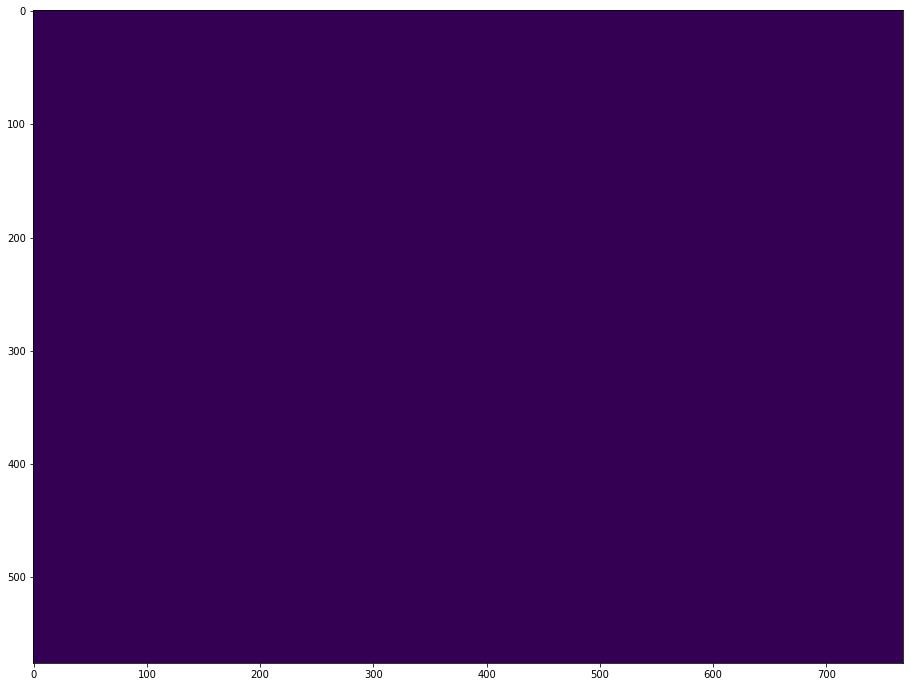

ImageGrid(
  Grid size: (144, 192, 3)
  (_preactivation): Identity()
  (activation): ReLU()
  (_clipper): HardClipActivation()
)


In [9]:
image_grid_rf = ImageGrid((int(image_height / 4), 
                           int(image_width / 4)),
                          use_relu_field=True).to(device)
_ = image_grid_rf.train(torch.from_numpy(image).to(device), num_iterations=1000)

In [ ]:
plt.figure(figsize=fig_size)
plt.title("GT alpha")
plt.imshow(image, cmap="gray")
plt.imsave(vis_save_path / "gt_alpha.png", np.tile(image, (1, 1, 3)))
plt.show()


plt.figure(figsize=fig_size)
plt.title("Rendered alpha at full resolution")
plt.imshow(image_grid_rf.render(), cmap="gray")
plt.imsave(vis_save_path / "rendered_reLU_field_alpha.png", image_grid_rf.render())
plt.show()

Displaying the stagewise training_images
Starting training ... please stand by.
Training stage: 1   grid_resolution: torch.Size([5, 6, 3])
current learning rate: 0.03
step: 100  loss: 0.015792887657880783  psnr: 18.015384539547476
step: 200  loss: 0.015773266553878784  psnr: 18.0207835743727
step: 300  loss: 0.015829769894480705  psnr: 18.005253981056548
step: 400  loss: 0.015773091465234756  psnr: 18.020831782810514
step: 500  loss: 0.015756305307149887  psnr: 18.025456125337605
step: 600  loss: 0.01571446843445301  psnr: 18.037003050624563
step: 700  loss: 0.01574268378317356  psnr: 18.0292122795747
step: 800  loss: 0.01578020676970482  psnr: 18.01887310483157
step: 900  loss: 0.015748057514429092  psnr: 18.027730077658838
step: 999  loss: 0.01568196527659893  psnr: 18.045995121044573
step: 1000  loss: 0.015710588544607162  psnr: 18.038075452663566
Training for stage 1 is now complete. Rendered RF grid:


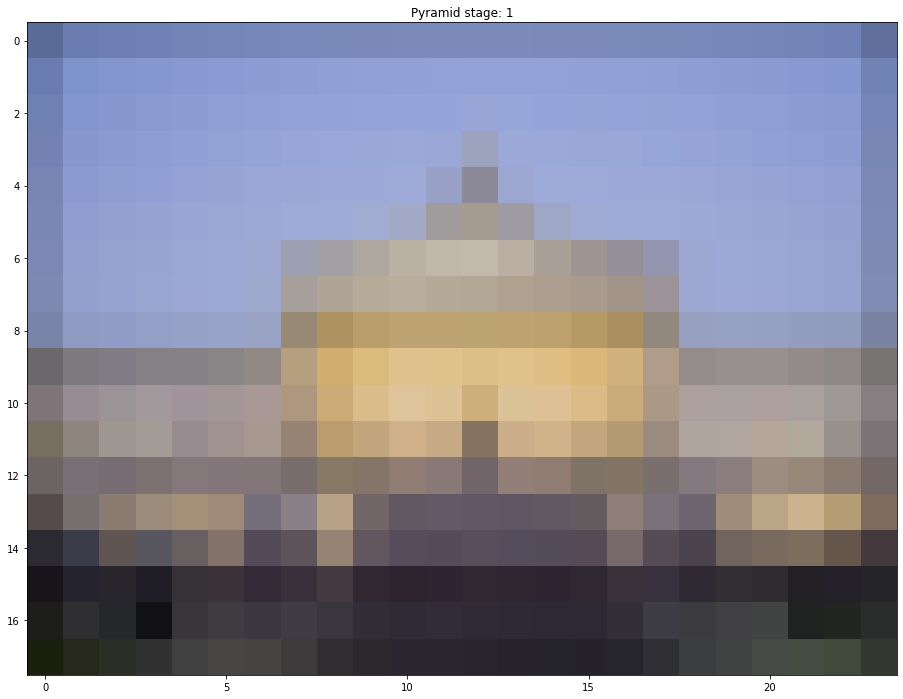

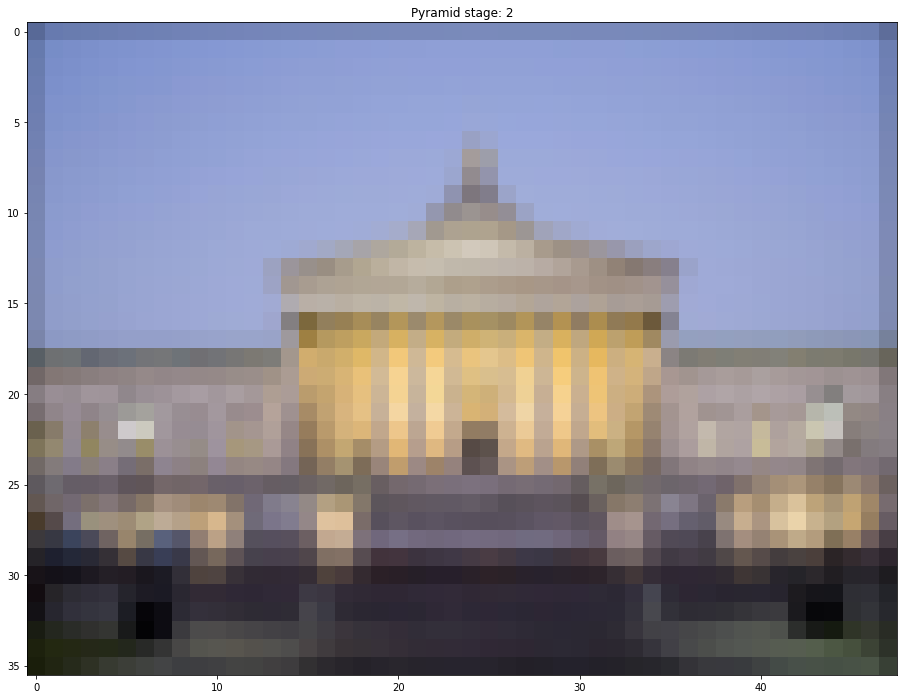

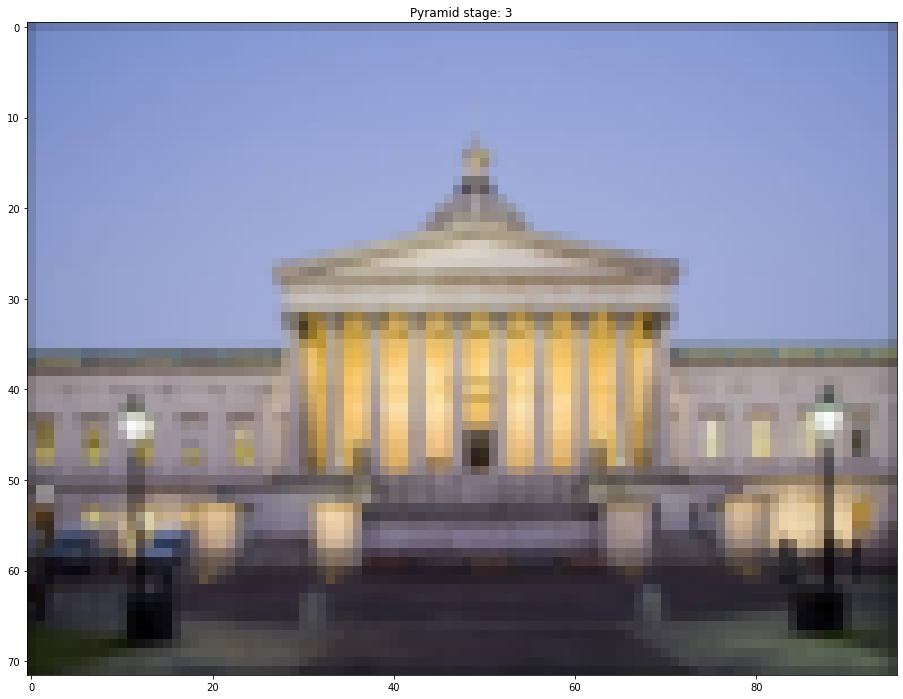

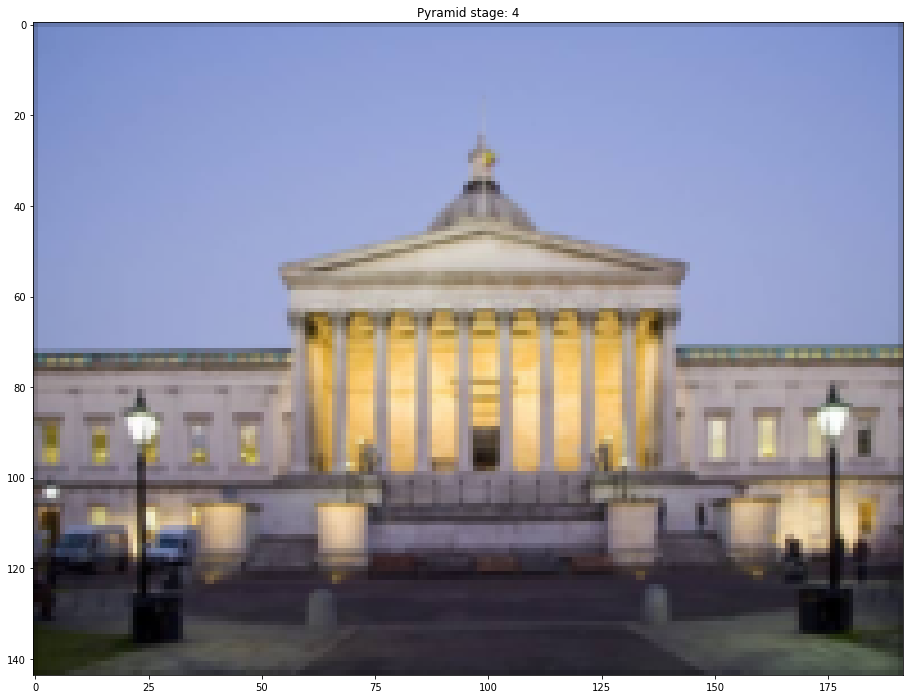

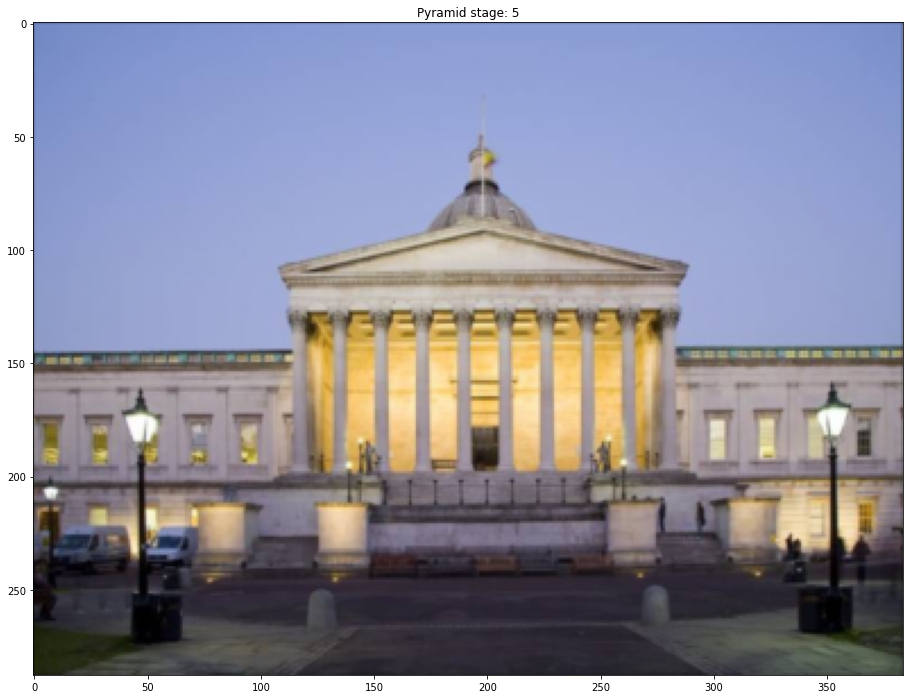

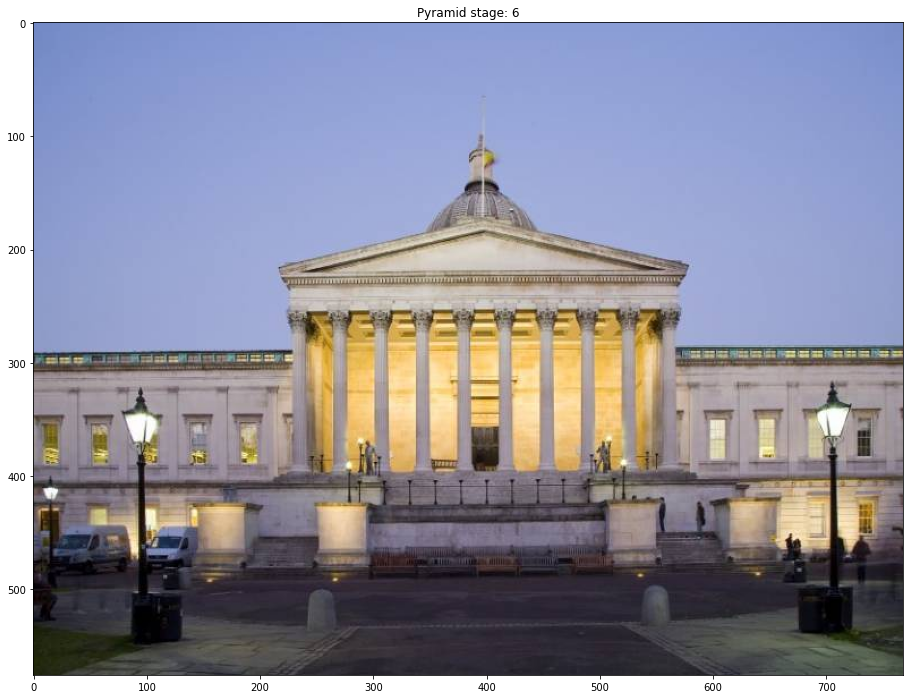

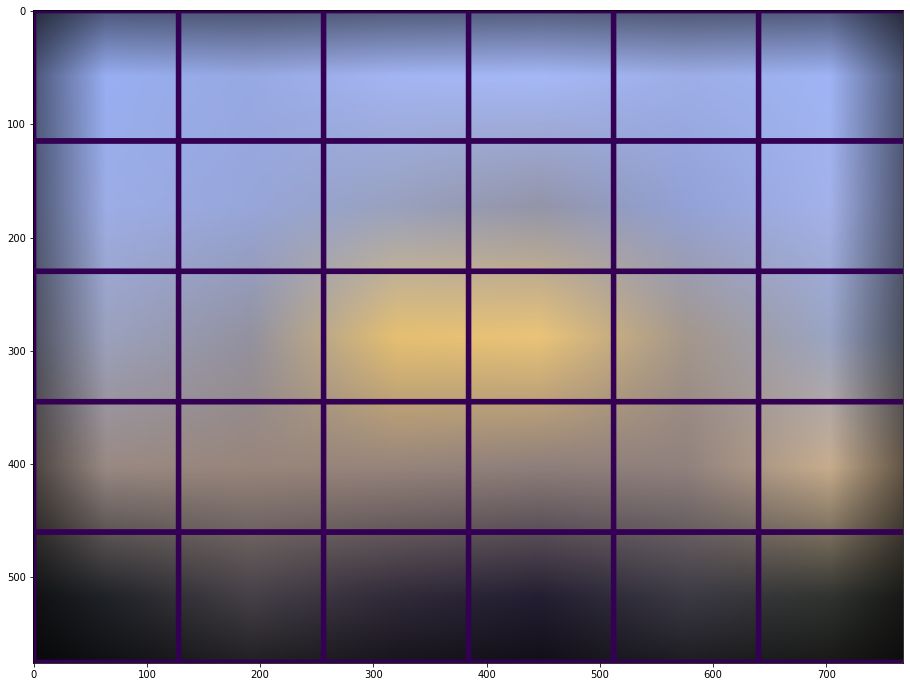

ImageGrid(
  Grid size: (144, 192, 3)
  (activation): Identity()
  (_clipper): HardClipActivation()
)
Training stage: 2   grid_resolution: torch.Size([9, 12, 3])
current learning rate: 0.03
step: 100  loss: 0.012734517455101013  psnr: 18.950175069671403
step: 200  loss: 0.012750511057674885  psnr: 18.944724077727663
step: 300  loss: 0.012752489186823368  psnr: 18.944050360465248
step: 400  loss: 0.012732788920402527  psnr: 18.950764604403826
step: 500  loss: 0.012752552516758442  psnr: 18.944028793089153
step: 600  loss: 0.012794786132872105  psnr: 18.929669690257025
step: 700  loss: 0.012784919701516628  psnr: 18.933019953105237
step: 800  loss: 0.01273629441857338  psnr: 18.94956910121176
step: 900  loss: 0.01277864445000887  psnr: 18.9351521340022
step: 999  loss: 0.012765174731612206  psnr: 18.939732361315183
step: 1000  loss: 0.012764643877744675  psnr: 18.93991297121996
Training for stage 2 is now complete. Rendered RF grid:


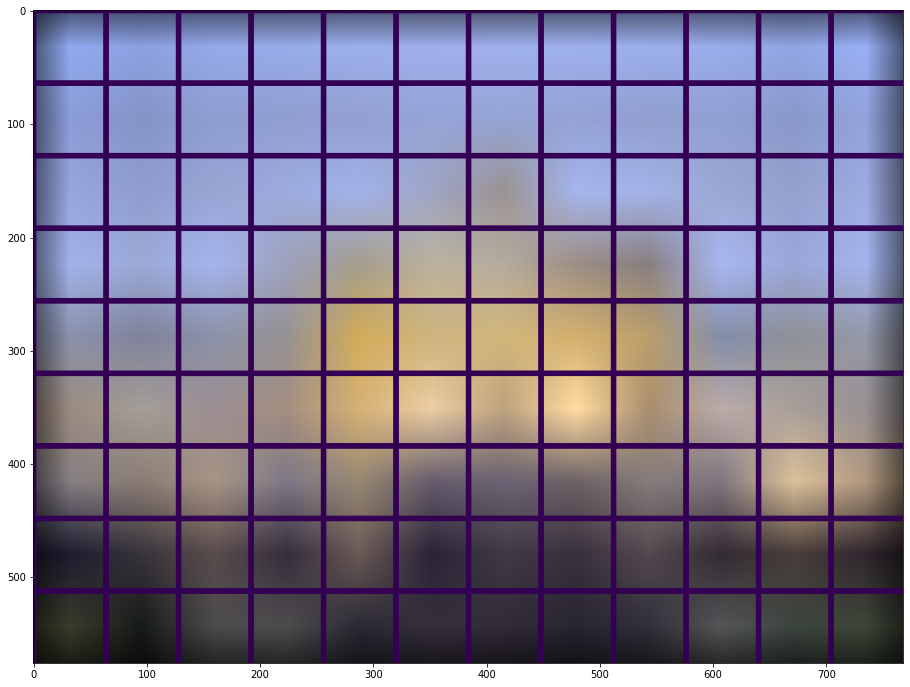

ImageGrid(
  Grid size: (144, 192, 3)
  (activation): Identity()
  (_clipper): HardClipActivation()
)
Training stage: 3   grid_resolution: torch.Size([18, 24, 3])
current learning rate: 0.03
step: 100  loss: 0.008315243758261204  psnr: 20.801250150775253
step: 200  loss: 0.008307626470923424  psnr: 20.80523038528808
step: 300  loss: 0.008317984640598297  psnr: 20.799818859077963
step: 400  loss: 0.008333282545208931  psnr: 20.79183892895951
step: 500  loss: 0.008321858942508698  psnr: 20.797796498755986
step: 600  loss: 0.008330280892550945  psnr: 20.793403541720668
step: 700  loss: 0.008288132958114147  psnr: 20.815432905968944
step: 800  loss: 0.00829114019870758  psnr: 20.81385741107547
step: 900  loss: 0.008318675681948662  psnr: 20.799458070987583
step: 999  loss: 0.008330162614583969  psnr: 20.793465205707424
step: 1000  loss: 0.008335862308740616  psnr: 20.790494676347652
Training for stage 3 is now complete. Rendered RF grid:


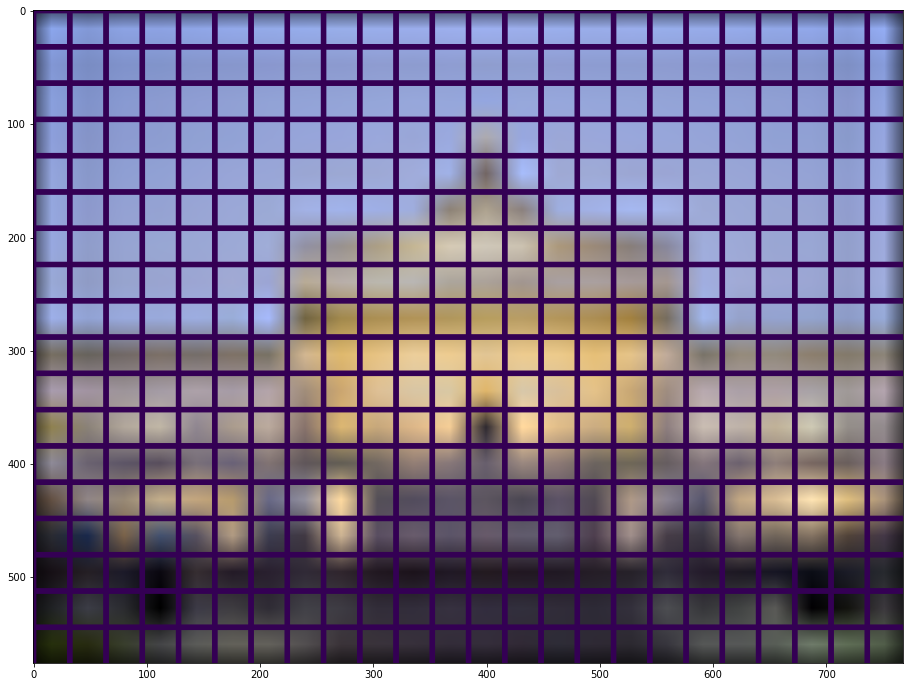

ImageGrid(
  Grid size: (144, 192, 3)
  (activation): Identity()
  (_clipper): HardClipActivation()
)
Training stage: 4   grid_resolution: torch.Size([36, 48, 3])
current learning rate: 0.03
step: 100  loss: 0.005085762124508619  psnr: 22.936439568675947
step: 200  loss: 0.005124696530401707  psnr: 22.90331847164725
step: 300  loss: 0.005049527157098055  psnr: 22.967492877580824
step: 400  loss: 0.005053185857832432  psnr: 22.964347279745883
step: 500  loss: 0.005093845538794994  psnr: 22.929542283292257
step: 600  loss: 0.005085030570626259  psnr: 22.937064318042875
step: 700  loss: 0.005093575455248356  psnr: 22.929772559029473
step: 800  loss: 0.005100409034639597  psnr: 22.923949936346936
step: 900  loss: 0.005021194461733103  psnr: 22.991929588642034
step: 999  loss: 0.0050500244833528996  psnr: 22.967065163448456
step: 1000  loss: 0.005075810011476278  psnr: 22.944946419972812
Training for stage 4 is now complete. Rendered RF grid:


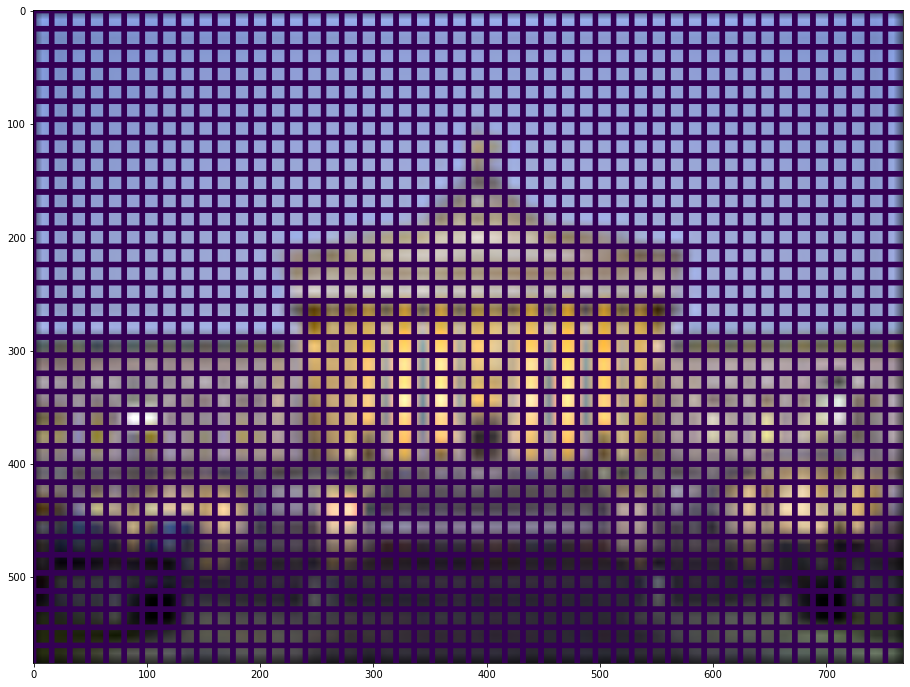

ImageGrid(
  Grid size: (144, 192, 3)
  (activation): Identity()
  (_clipper): HardClipActivation()
)
Training stage: 5   grid_resolution: torch.Size([72, 96, 3])
current learning rate: 0.03
step: 100  loss: 0.0026847117114812136  psnr: 25.71102342677596
step: 200  loss: 0.0027000943664461374  psnr: 25.68621057281507
step: 300  loss: 0.002694405149668455  psnr: 25.695371001364805
step: 400  loss: 0.002708968473598361  psnr: 25.671960491646672
step: 500  loss: 0.002690928755328059  psnr: 25.70097800406993
step: 600  loss: 0.002703925361856818  psnr: 25.680053006672
step: 700  loss: 0.0026878931093961  psnr: 25.705880060506786
step: 800  loss: 0.0026985956355929375  psnr: 25.688621863538845
step: 900  loss: 0.0027115875855088234  psnr: 25.66776363093232
step: 999  loss: 0.0026948335580527782  psnr: 25.694680531308475
step: 1000  loss: 0.002696002135053277  psnr: 25.692797682044144
Training for stage 5 is now complete. Rendered RF grid:


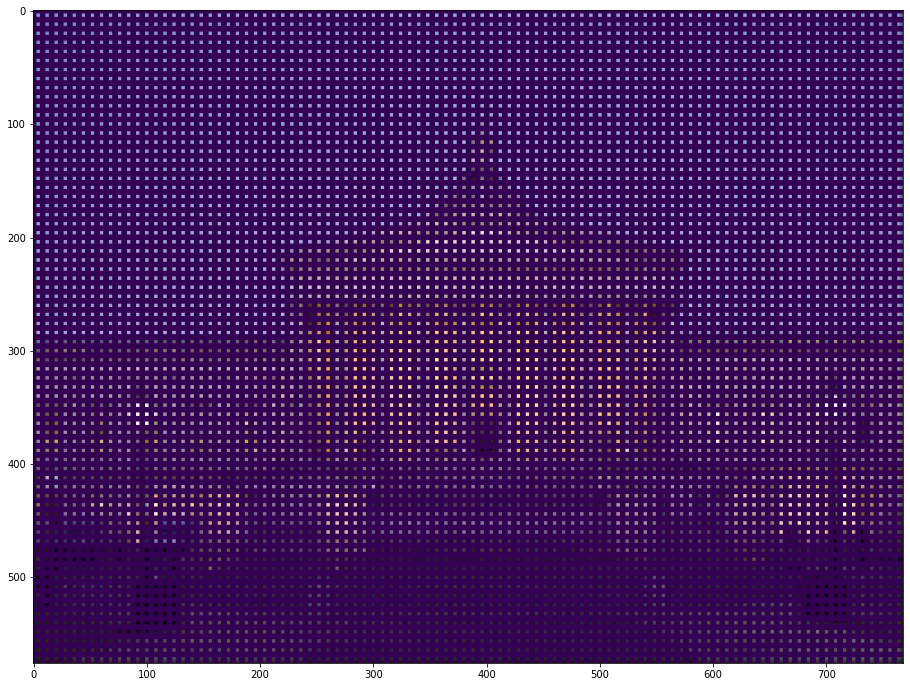

ImageGrid(
  Grid size: (144, 192, 3)
  (activation): Identity()
  (_clipper): HardClipActivation()
)
Training stage: 6   grid_resolution: torch.Size([144, 192, 3])
current learning rate: 0.03
step: 100  loss: 0.0011123433941975236  psnr: 29.53761119963544
step: 200  loss: 0.0011120549170300364  psnr: 29.538737652951507
step: 300  loss: 0.001117595238611102  psnr: 29.517154571527588
step: 400  loss: 0.0011069730389863253  psnr: 29.5586295650344
step: 500  loss: 0.0011143420124426484  psnr: 29.52981495589309
step: 600  loss: 0.0011194702237844467  psnr: 29.509874535079845
step: 700  loss: 0.0011168575147166848  psnr: 29.520022293189438
step: 800  loss: 0.0011069225147366524  psnr: 29.558827789406838
step: 900  loss: 0.001102598151192069  psnr: 29.57582740069842
step: 999  loss: 0.001110395067371428  psnr: 29.54522476120243
step: 1000  loss: 0.0011116983368992805  psnr: 29.54013044043094
Training for stage 6 is now complete. Rendered RF grid:


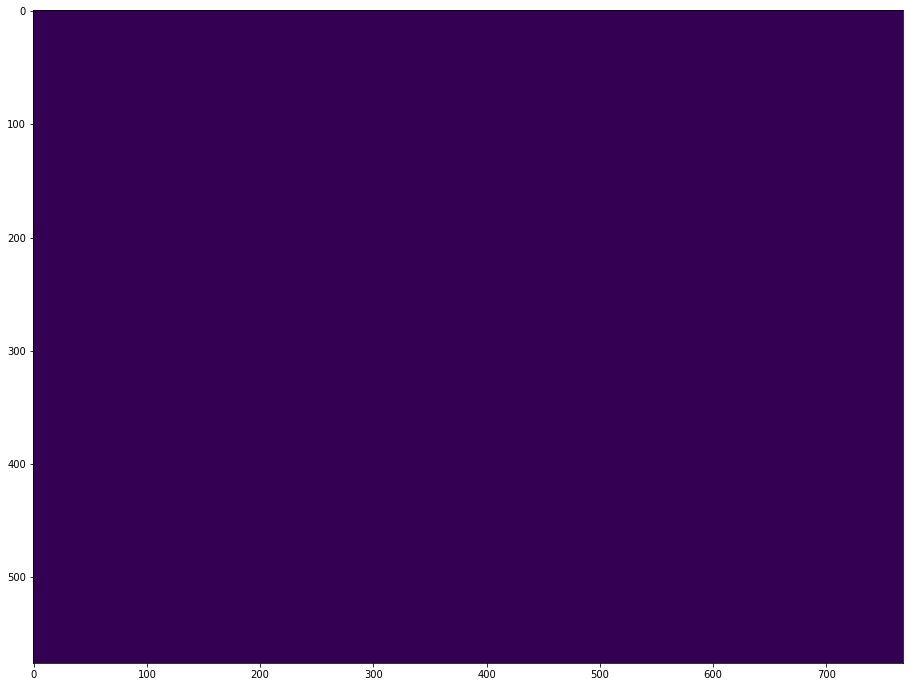

ImageGrid(
  Grid size: (144, 192, 3)
  (activation): Identity()
  (_clipper): HardClipActivation()
)


In [10]:
image_grid_grid = ImageGrid((int(image_height / 4), 
                             int(image_width / 4)),  
                            use_relu_field=False).to(device)
_ = image_grid_grid.train(torch.from_numpy(image).to(device), num_iterations=1000)

In [ ]:
plt.figure(figsize=fig_size)
plt.title("GT alpha")
plt.imshow(image, cmap="gray")
plt.show()

plt.figure(figsize=fig_size)
plt.title("Rendered alpha at full resolution")
plt.imshow(image_grid_grid.render(), cmap="gray")
plt.imsave(vis_save_path / "rendered_trad_grid_alpha.png", image_grid_grid.render())
plt.show()

## Experiments/ method sweeps

In [ ]:
relu_images_output_path = output_dir / "coarse_to_fine"
relu_images_output_path.mkdir(parents=True, exist_ok=True)
imageio.imwrite(relu_images_output_path / f"trad_grid_final_render.png", image_grid.to8b(image_grid.render()))

In [ ]:
grid_downsample_factors = [1, 2, 4, 8, 16, 32, 64]
relu_experiment_results = {}

relu_trained_image_grids = []
for experiment, gds in enumerate(grid_downsample_factors, start=1):
    image_grid = ImageGrid((int(image_height / gds), int(image_width / gds)), 
                           num_channels=3, 
                           use_relu_field=True).to(device)
    log_buffer = image_grid.train(torch.from_numpy(image), num_iterations=1000)
    relu_trained_image_grids.append(image_grid)
    relu_experiment_results[f"{gds}"] = log_buffer

Save all the trained image_grid models to disk

In [ ]:
output_path = output_dir / "relu_models"
output_path.mkdir(parents=True, exist_ok=True)
for grid_num, image_grid in enumerate(relu_trained_image_grids, start=1):
    torch.save(image_grid.get_save_info(), output_path / f"{grid_num}.pth")

In [ ]:
grid_downsample_factors = [1, 2, 4, 8, 16, 32, 64]
normal_experiment_results = {}

normal_trained_image_grids = []
for experiment, gds in enumerate(grid_downsample_factors, start=1):
    image_grid = ImageGrid((int(image_height / gds), int(image_width / gds)), 
                           num_channels=3, 
                           use_relu_field=False).to(device)
    log_buffer = image_grid.train(torch.from_numpy(image), num_iterations=1000)
    normal_trained_image_grids.append(image_grid)
    normal_experiment_results[f"{gds}"] = log_buffer

In [ ]:
output_path = output_dir / "normal_models"
output_path.mkdir(parents=True, exist_ok=True)
for grid_num, image_grid in enumerate(normal_trained_image_grids, start=1):
    torch.save(image_grid.get_save_info(), output_path / f"{grid_num}.pth")

Plot the PSNR v/s Grid-downsample_factor for the two cases

In [ ]:
downsample_factors = list(map(int, relu_experiment_results.keys()))
relu_final_psnrs = [exp["psnr"][-1] for _, exp in relu_experiment_results.items()]
normal_final_psnrs = [exp["psnr"][-1] for _, exp in normal_experiment_results.items()]

plt.figure(figsize=(20, 8))
plt.title("2D Image Normal-Grid v/s ReLUFields")
plt.xlabel('grid_downsample_factor', fontsize=16)
plt.ylabel('PSNR', fontsize=16)
plt.plot(downsample_factors, relu_final_psnrs, label='ReLUField grid')
plt.plot(downsample_factors, normal_final_psnrs, label='Normal grid')
plt.legend()
plt.savefig(output_path / "comparison.png",dpi=500)
plt.show()


Save the renders of all the models to disk

In [ ]:
relu_images_output_path = output_dir / "renders/relu_models"
relu_images_output_path.mkdir(parents=True, exist_ok=True)
for grid_num, image_grid in enumerate(relu_trained_image_grids, start=1):
    imageio.imwrite(relu_images_output_path / f"{grid_num}.png", image_grid.to8b(image_grid.render()))
    
normal_images_output_path = output_dir / "renders/normal_models"
normal_images_output_path.mkdir(parents=True, exist_ok=True)
for grid_num, image_grid in enumerate(normal_trained_image_grids, start=1):
    imageio.imwrite(normal_images_output_path / f"{grid_num}.png", image_grid.to8b(image_grid.render()))

Experiments with different activation functions ....

In [ ]:
# Defining the activation functions 
class ShiftedTanh(torch.nn.Module):
    def forward(self, x):
        return torch.tanh(x) * 0.5 + 0.5

class ExpDecay(torch.nn.Module):
    def forward(self, x):
        clipped_x = torch.nn.functional.softplus(x)
        return 1 - torch.exp(-clipped_x)


RELU = None
SOFTPLUS = torch.nn.Sequential(torch.nn.Softplus(), ImageGrid.ClipActivation())
SIGMOID = torch.nn.Sigmoid()
TANH = ShiftedTanh()
EXP = ExpDecay()

In [ ]:
activation_functions = [RELU, SOFTPLUS, SIGMOID, TANH, EXP]
activation_names = ["RELUField", "Softplus", "Sigmoid", "Tanh", "Exp"]
activation_experiment_results = {}
activation_trained_image_grids = []
gds = 4

for experiment, (act_name, activation_fn) in enumerate(zip(activation_names, activation_functions), start=1):
    image_grid = ImageGrid((int(image_height / gds), int(image_width / gds)), 
                           num_channels=3,
                           activation=activation_fn,
                           use_relu_field=True).to(device)
    log_buffer = image_grid.train(torch.from_numpy(image), num_iterations=700)
    activation_trained_image_grids.append(image_grid)
    activation_experiment_results[f"{act_name}"] = log_buffer

In [ ]:
output_path = output_dir / "activation_models"
output_path.mkdir(parents=True, exist_ok=True)
for act_name, image_grid in zip(activation_names, activation_trained_image_grids):
    torch.save(image_grid.get_save_info(), output_path / f"{act_name}.pth")
    
activation_images_output_path = output_dir / "renders/activation_models"
activation_images_output_path.mkdir(parents=True, exist_ok=True)
for act_name, image_grid in zip(activation_names, activation_trained_image_grids):
    imageio.imwrite(activation_images_output_path / f"{act_name}.png", image_grid.to8b(image_grid.render()))

In [ ]:
plt.figure(figsize=(20, 8))
plt.title("ReLUFields v/s other activations")
plt.xlabel('training_steps', fontsize=16)
plt.ylabel('PSNR', fontsize=16)
for exp_name, exp_results in activation_experiment_results.items():
    psnrs = exp_results["psnr"][:700]
    plt.plot(range(len(psnrs)), psnrs, label=f'{exp_name}')
plt.legend()
plt.savefig(output_dir / "ActivationComparison.png",dpi=500)
plt.show()

Experiments on different interpolation modes:

In [ ]:
interpolation_modes = ["nearest", "bilinear", "bicubic"]
interpolation_experiment_results = {}
interpolation_trained_image_grids = []
gds = 4

for _, interp_mode in enumerate(interpolation_modes, start=1):
    image_grid = ImageGrid((int(image_height / gds), int(image_width / gds)), 
                           num_channels=3,
                           activation=None,
                           use_relu_field=True,
                           interpolation_mode=interp_mode).to(device)
    log_buffer = image_grid.train(torch.from_numpy(image), num_iterations=700)
    interpolation_trained_image_grids.append(image_grid)
    interpolation_experiment_results[f"{interp_mode}"] = log_buffer

In [ ]:
interpolation_modes = ["nearest", "bilinear", "bicubic"]
interpolation_experiment_results = {}
interpolation_trained_image_grids = []
gds = 4

for _, interp_mode in enumerate(interpolation_modes, start=1):
    image_grid = ImageGrid((int(image_height / gds), int(image_width / gds)), 
                           num_channels=3,
                           activation=None,
                           use_relu_field=False,
                           interpolation_mode=interp_mode).to(device)
    log_buffer = image_grid.train(torch.from_numpy(image), num_iterations=700)
    interpolation_trained_image_grids.append(image_grid)
    interpolation_experiment_results[f"{interp_mode}"] = log_buffer

In [ ]:
output_path = output_dir / "interpolation_models"
output_path.mkdir(parents=True, exist_ok=True)
for interp_mode, image_grid in zip(interpolation_modes, interpolation_trained_image_grids):
    torch.save(image_grid.get_save_info(), output_path / f"{interp_mode}.pth")
    
interpolation_images_output_path = output_dir / "renders/interpolation_models"
interpolation_images_output_path.mkdir(parents=True, exist_ok=True)
for interp_mode, image_grid in zip(interpolation_modes, interpolation_trained_image_grids):
    imageio.imwrite(interpolation_images_output_path / f"{interp_mode}.png", image_grid.to8b(image_grid.render()))

In [ ]:
plt.figure(figsize=(20, 8))
plt.title("ReLUFields interpolation_modes")
plt.xlabel('training_steps', fontsize=16)
plt.ylabel('PSNR', fontsize=16)
for exp_name, exp_results in interpolation_experiment_results.items():
    psnrs = exp_results["psnr"][:700]
    plt.plot(range(len(psnrs)), psnrs, label=f'{exp_name}')
plt.legend()
plt.savefig(output_dir / "InterpolationComparison.png",dpi=500)
plt.show()

Pickle all the experiments data in a single dictionary ... 

In [ ]:
all_results = {
    "relu_grid_sizes": relu_experiment_results,
    "normal_grid_sizes": normal_experiment_results,
    "activation_relufields": activation_experiment_results,
    "interpolation_relufields": interpolation_experiment_results
}

with open(f'{output_dir}/all_results.pickle', 'wb') as handle:
    pickle.dump(all_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

### That's all Folks!